In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization

2025-07-23 08:17:11.115136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 08:17:11.423427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753240631.534857    1100 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753240631.567921    1100 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753240631.819164    1100 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Positional Encoding
#### Angles

In [2]:
def get_angles(pos, k, d):
    i = k//2
    angles = pos / (10000)**((2*i)/d)
    return angles

In [3]:
def positional_encoding(positions, d):
    angle_radius = get_angles(np.arange(positions)[:, np.newaxis], np.arange(d)[np.newaxis,:],d)
    
    angle_radius[:, 0::2] = np.sin(angle_radius[:, 0::2])
    angle_radius[:, 1::2] = np.cos(angle_radius[:, 1::2])
    
    pos_encoding = angle_radius[np.newaxis, ...]
    return pos_encoding

(1, 50, 512)


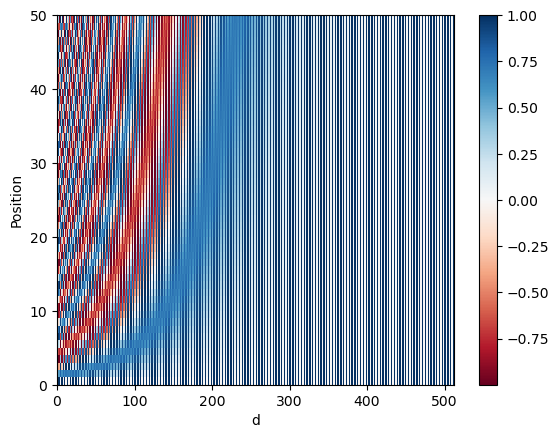

In [4]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking
#### Padding Mask
setting 0 to negative infinity so it does not effect softmax

In [5]:
def create_padding_mask(decoder_token_ids):
    mask = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
    return mask[:, tf.newaxis, :]

#### Look Ahead Mask

In [6]:
def create_look_ahead_mask(sequence_length):
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask

## Self-Attention

In [7]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, tf.transpose(k))
    
    dk = matmul_qk / tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    
    if mask is not None:
        dk += ((1 - mask) * -1e9)

    attention_weights = tf.keras.activations.softmax(dk)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

## Encoder
#### Encoder Layer

In [8]:
def feed_forward(embedding_dim, dense_units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dense_dim, dropout=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout)

        self.ffn = feed_forward(embedding_dim, dense_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout)

    def call(self, x, training, mask):

        mha_output = self.mha(x, x, x, attention_mask=mask, training=training)

        skip_x_attention = self.layernorm1(x + mha_output)

        ffn_output = self.ffn(skip_x_attention)
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        encoder_layer_out = self.layernorm1(skip_x_attention + ffn_output)
        
        return encoder_layer_out
        

#### Full Encoder

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, dense_dim, input_vocab_size, 
                 maximum_position_encoding, dropout=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim, num_heads=num_heads, 
                                        dense_dim=dense_dim, dropout=dropout, layernorm_eps=layernorm_eps) for i in range(self.num_layers)]

        self.dropout = Dropout(dropout)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, dtype='float32'))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training) 

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        
        return x


## Decoder
#### Decoder Layer

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dense_dim, dropout=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout)

        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout)

        self.ffn = feed_forward(embedding_dim, dense_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        mha_out1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask, training=training, return_attention_scores=True)

        Q1 = self.layernorm1(x + mha_out1)

        mha_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, attention_mask=padding_mask, training=training, return_attention_scores=True)

        mha_out2 = self.layernorm2(Q1 + mha_out2)

        ffn_output = self.ffn(mha_out2)
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        out3 = self.layernorm3(mha_out2 + ffn_output)

        return out3, attn_weights_block1, attn_weights_block2
        

#### Full Decoder

In [39]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, dense_dim, target_vocab_size, 
                 maximum_position_encoding, dropout=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=embedding_dim, num_heads=num_heads, dense_dim=dense_dim, 
                                        dropout=dropout, layernorm_eps=layernorm_eps) for i in range(self.num_layers)]

        self.dropout = Dropout(dropout)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, dtype="float32"))

        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            attention_weights[f"decoder_layer{i+1}_block1_self_att"] = block1
            attention_weights[f"decoder_layer{i+1}_block2_decenc_att"] = block2

        return x, attention_weights

## Transform Network

In [41]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, embedding_dim, num_heads, dense_dim, input_vocab_size, 
                 target_vocab_size, max_positional_encoding_input, max_positional_encoding_target, dropout=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, embedding_dim=embedding_dim, dense_dim=dense_dim, 
                               input_vocab_size=input_vocab_size, maximum_position_encoding=max_positional_encoding_input,
                              dropout=dropout, layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, num_heads=num_heads, embedding_dim=embedding_dim, dense_dim=dense_dim, 
                               target_vocab_size=target_vocab_size, maximum_position_encoding=max_positional_encoding_target,
                              dropout=dropout, layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(input_sentence, training=training, mask=enc_padding_mask)

        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights